#訓練CNN模型來分辨宋芸樺/夏于喬
![](https://cdn.bella.tw/files-20211012/0000(1).jpg)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/CNN/

/content/drive/My Drive/CNN


In [ ]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.optimizers import SGD, Adam

In [ ]:
class_names = ['Vivian','Kimi']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [ ]:
def load_data():
    datasets = ['train', 'test'] #資料夾
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #cv讀照片，顏色默認為BGR，需轉為RGB，錯誤表示黑白或已轉
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')

        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading train


100%|██████████| 802/802 [00:16<00:00, 47.53it/s] 


Loading test


100%|██████████| 100/100 [00:01<00:00, 62.49it/s]


In [ ]:
#隨機性
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
#標準化
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
input_shape = (150, 150, 3)

model = Sequential([
    Conv2D(50, (3, 3), input_shape=input_shape, padding='same',
           activation='relu', strides=2),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    Conv2D(75, (3, 3), input_shape=input_shape, padding='same',
           activation='relu', strides=2),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    Flatten(),
    Dropout(0.5),
    Dense(2, activation='softmax') #輸出層，分類用softmax
])

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

# 建立早停回調函數
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(train_images, train_labels,
           batch_size=80, epochs=100,
           validation_split=0.1, verbose=1,callbacks=[early_stopping])

Epoch 1/100
19/19 [==============================] - 2s 46ms/step - loss: 0.6764 - accuracy: 0.5604 - val_loss: 0.6466 - val_accuracy: 0.7143
Epoch 2/100
19/19 [==============================] - 1s 29ms/step - loss: 0.5925 - accuracy: 0.6874 - val_loss: 0.5993 - val_accuracy: 0.6273
Epoch 3/100
19/19 [==============================] - 1s 28ms/step - loss: 0.5315 - accuracy: 0.7378 - val_loss: 0.5260 - val_accuracy: 0.7081
Epoch 4/100
19/19 [==============================] - 1s 28ms/step - loss: 0.4861 - accuracy: 0.7681 - val_loss: 0.4929 - val_accuracy: 0.8075
Epoch 5/100
19/19 [==============================] - 1s 28ms/step - loss: 0.4454 - accuracy: 0.7971 - val_loss: 0.4631 - val_accuracy: 0.8137
Epoch 6/100
19/19 [==============================] - 1s 31ms/step - loss: 0.4026 - accuracy: 0.8171 - val_loss: 0.4759 - val_accuracy: 0.8323
Epoch 7/100
19/19 [==============================] - 1s 35ms/step - loss: 0.3897 - accuracy: 0.8254 - val_loss: 0.4236 - val_accuracy: 0.8199
Epoch 

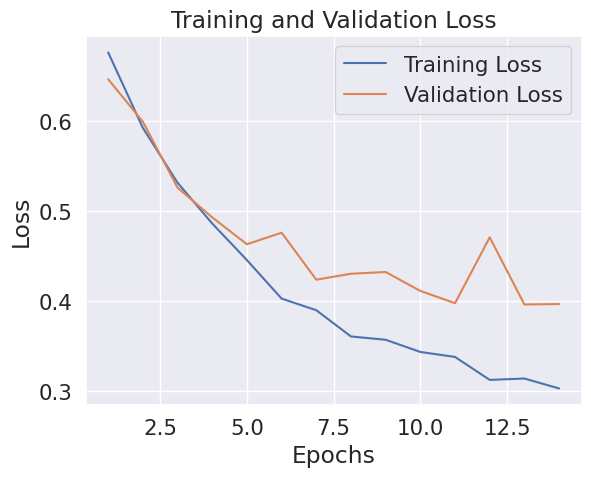

In [ ]:
# 獲取訓練過程中的損失函數值和驗證損失函數值
losses = history.history['loss']
val_losses = history.history['val_loss']
epochs = range(1, len(losses) + 1)

# 繪製訓練損失函數值和驗證損失函數值的變化
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(test_images, test_labels)
scores

7/7 [==============================] - 0s 6ms/step - loss: 0.3729 - accuracy: 0.8450


[0.3728867471218109, 0.8450000286102295]

In [ ]:
#預測
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

7/7 [==============================] - 0s 6ms/step


In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements
print(accuracy(CM))

0.845


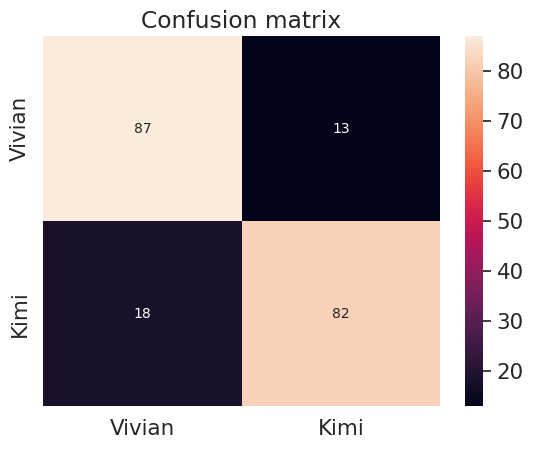

In [ ]:
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=class_names,
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
#存模型
from keras.models import load_model
model.save("model")